<a href="https://colab.research.google.com/github/HYChangTAMU/Financial-Data-Analysis/blob/main/Assignment5/Project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Date 12/01/2023

#-------------------------------------------------------------------------------

!pip install mat73
!pip install ZCAPM
import mat73
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import json
import datetime
import pytz
import ZCAPM
from statsmodels.stats.weightstats import ttest_ind, ttost_paired
from sklearn.metrics import r2_score
from google.colab import files


#-------------------------------------------------------------------------------

a_factors = pd.read_csv('/content/drive/MyDrive/Assignment5/mu_sigma_vwt_2022.csv')
a_factors.rename({'DATE': 'Date'}, axis=1, inplace=True)
# a_factors.rename({'VWRETD-Rf': 'R_a.R_f', 'VWStd': 'sigma_a'}, axis=1, inplace=True)


#-------------------------------------------------------------------------------

f6 = pd.read_csv('/content/drive/MyDrive/Assignment4/data/6_factors_daily.csv')
f6.drop(range(14979, 15123), inplace = True)


#-------------------------------------------------------------------------------

daily_return = pd.DataFrame(mat73.loadmat('/content/drive/MyDrive/Assignment4/data/stock_daily_return.mat')['stock_ret'])
daily_return[0] = daily_return[0].astype('int64')
daily_return.rename({0: 'Date'}, axis=1, inplace=True)
daily_return.drop(range(879), inplace = True)
daily_return.reset_index(drop = True, inplace = True)


#-------------------------------------------------------------------------------

# start and end of 714 months
# month_start_end records the dates
# month_start_end_index records the indices

month_start_end = []
dates = a_factors['Date'][0:-1].tolist()
for i, d in enumerate(dates):
  if d%100 < dates[i-1]%100:
    month_start_end.append(dates[i-1])
    month_start_end.append(d)
month_start_end.append(month_start_end[0])
month_start_end = month_start_end[1:]

mse_index = []
for i in range(len(month_start_end)//2):
  mse_index.append(a_factors['Date'].index[a_factors['Date'] == month_start_end[2*i]].tolist())
  mse_index.append(a_factors['Date'].index[a_factors['Date'] == month_start_end[2*i + 1]].tolist())

month_start_end_index = []
for i in range(len(month_start_end)):
  month_start_end_index.append(mse_index[i][0])
month_start_end[-1] = 20221230
month_start_end_index[-1] = 14978


#-------------------------------------------------------------------------------

dates_conv = a_factors[['Date']]
Date = pd.to_datetime(dates_conv['Date'], format="%Y%m%d").dt.date
YearMonth = dates_conv['Date'].apply(lambda x: x//100)
YearMonth.rename('YearMonth', inplace = True)
a_factors = a_factors.assign(Date = Date).assign(YearMonth = YearMonth)[['Date', 'YearMonth', 'VWRETD-Rf', 'VWStd', 'Rf']]

In [18]:
def window_data(n):
  # n_min = 0
  # n_max = 701
  fac_data = a_factors[month_start_end_index[2*n]:month_start_end_index[2*n+25]+1]
  # fac_data.drop(columns = 'Date', inplace = True)

  ret_data = daily_return[month_start_end_index[2*n]:month_start_end_index[2*n+25]+1]
  ret_data.dropna(how = 'any', axis = 1, inplace = True)
  ret_data.columns = [str(x) for x in ret_data.columns]
  ret_data.drop(columns = 'Date', inplace = True)
  ret_data = ret_data.sub(fac_data['Rf'], axis = 0)

  fac_data.drop(columns = 'Rf', inplace = True)

  win_data = ret_data.join(fac_data, how = 'inner')
  win_data.set_index('Date', inplace = True)

  cols = win_data.columns.to_list()

  ex_ret = win_data[cols[-3:-2] + cols[:-3]]
  ex_ret.set_index('YearMonth', inplace = True)

  mu_sigma = win_data[cols[-3:]]
  #mu_sigma.set_index('YearMonth', inplace = True)

  months = sorted(list(set(mu_sigma['YearMonth'].tolist())))

  return ex_ret, mu_sigma.set_index('YearMonth')['VWRETD-Rf'], mu_sigma.set_index('YearMonth')['VWStd'], months


#-------------------------------------------------------------------------------

# for n in range(702):
#   ex_ret, mu , sigma, months = window_data(n)
#   ex_ret.to_csv("/content/drive/MyDrive/Assignment5/Window Returns/ex_ret_" + str(n))
#   mu.to_csv("/content/drive/MyDrive/Assignment5/Window mu/mu_" + str(n))
#   sigma.to_csv("/content/drive/MyDrive/Assignment5/Window sigma/sigma_" + str(n))

#   with open("/content/drive/MyDrive/Assignment5/Window months/months_" + str(n), "w") as save_months:
#    json.dump(months, save_months)


#-------------------------------------------------------------------------------

# model = ZCAPM.Testing()

# for n in range(352):
# # after window 351, the RAM is not enough, and the system will crash.

#   tol = .001
#   MaxIter = 1000
#   criterion = 2
#   width = 12

#   stock_ex_ret = pd.read_csv('/content/drive/MyDrive/Assignment5/Window Returns/ex_ret_' + str(n), index_col = 'YearMonth')
#   mu = pd.read_csv('/content/drive/MyDrive/Assignment5/Window mu/mu_' + str(n), index_col = 'YearMonth')['VWRETD-Rf']
#   sigma = pd.read_csv('/content/drive/MyDrive/Assignment5/Window sigma/sigma_' + str(n), index_col = 'YearMonth')['VWStd']
#   # with open("/content/drive/MyDrive/Assignment5/Window months/months_" + str(n), "r") as read_months:
#   #   months = json.load(read_months)

#   zcapm_results = model.estZCAPM(stock_ex_ret,mu,sigma,tol,MaxIter,criterion,width)

#   cols = stock_ex_ret.columns

#   beta_cols = zcapm_results.columns[zcapm_results.columns.str.contains('beta')]
#   zeta_cols = zcapm_results.columns[zcapm_results.columns.str.contains('zeta')]

#   zcapm_beta = zcapm_results[beta_cols]
#   zcapm_beta.columns = cols
#   zcapm_beta.reset_index(drop = True, inplace = True)
#   zcapm_beta.rename(index = {0: 'beta'}, inplace = True)

#   zcapm_zeta = zcapm_results[zeta_cols]
#   zcapm_zeta.columns = cols
#   zcapm_zeta.reset_index(drop = True, inplace = True)
#   zcapm_zeta.rename(index = {0: 'zeta'}, inplace = True)

#   zcapm_results = pd.concat([zcapm_beta, zcapm_zeta], axis=0)

#   zcapm_results.to_csv('/content/drive/MyDrive/Assignment5/betas/betas_' + str(n))


#-------------------------------------------------------------------------------

model = ZCAPM.Testing()

print('start running at ' + datetime.datetime.now(pytz.timezone('US/Central')).strftime("%Y-%m-%d %H:%M:%S"))
for n in range(356, 702):
  betas_dict = {}

  stock_ex_ret = pd.read_csv('/content/drive/MyDrive/Assignment5/Window Returns/ex_ret_' + str(n), index_col = 'YearMonth')
  mu = pd.read_csv('/content/drive/MyDrive/Assignment5/Window mu/mu_' + str(n), index_col = 'YearMonth')['VWRETD-Rf']
  sigma = pd.read_csv('/content/drive/MyDrive/Assignment5/Window sigma/sigma_' + str(n), index_col = 'YearMonth')['VWStd']
  # with open("/content/drive/MyDrive/Assignment5/Window months/months_" + str(n), "r") as read_months:
  #   months = json.load(read_months)
  cols = stock_ex_ret.columns
  for m in cols.tolist():
    tol = .001
    MaxIter = 1000
    criterion = 2
    width = 12

    zcapm_results = model.estZCAPM(stock_ex_ret[[m]],mu,sigma,tol,MaxIter,criterion,width)

    betas_dict[m] = [zcapm_results.iloc[0, 0], zcapm_results.iloc[0, 1]]

  betas_df = pd.DataFrame(betas_dict, index = ['beta', 'zeta'])
    # beta_cols = zcapm_results.columns[zcapm_results.columns.str.contains('beta')]
    # zeta_cols = zcapm_results.columns[zcapm_results.columns.str.contains('zeta')]

    # zcapm_beta = zcapm_results[beta_cols]
    # zcapm_beta.columns = cols
    # zcapm_beta.reset_index(drop = True, inplace = True)
    # zcapm_beta.rename(index = {0: 'beta'}, inplace = True)

    # zcapm_zeta = zcapm_results[zeta_cols]
    # zcapm_zeta.columns = cols
    # zcapm_zeta.reset_index(drop = True, inplace = True)
    # zcapm_zeta.rename(index = {0: 'zeta'}, inplace = True)

    # zcapm_results = pd.concat([zcapm_beta, zcapm_zeta], axis=0)

  betas_df.to_csv('/content/drive/MyDrive/Assignment5/betas/betas_' + str(n))
  print('finished window: ' + str(n) + ' at ' + datetime.datetime.now(pytz.timezone('US/central')).strftime("%Y-%m-%d %H:%M:%S"))

In [3]:
def read_betas(n, date_range = False):
  rdata = pd.read_csv('/content/drive/MyDrive/Assignment5/betas/betas_' + str(n), index_col = 'Unnamed: 0')
  rdata.index.name = None
  if date_range:
    print('date :', month_start_end[2*n], 'to', month_start_end[2*n+23])
    print('index:', month_start_end_index[2*n], 'to', month_start_end_index[2*n+23])
  return rdata


#-------------------------------------------------------------------------------

def double_sort(colm1, colm2):
  sort_group = [0 for x in range(702)]
  for n in range(702):
    sort_group[n] = [x.to_list() for x in np.array_split(read_betas(n, False).sort_values(by = [colm1], axis = 1, ascending = False).columns, 5)]
    sort_group[n] = [x.to_list() for x in np.array_split(read_betas(n, False)[sort_group[n][0]].sort_values(by = [colm2], axis = 1, ascending = False).columns, 5)] + [x.to_list() for x in np.array_split(read_betas(n, False)[sort_group[n][1]].sort_values(by = [colm2], axis = 1, ascending = False).columns, 5)] + [x.to_list() for x in np.array_split(read_betas(n, False)[sort_group[n][2]].sort_values(by = [colm2], axis = 1, ascending = False).columns, 5)] + [x.to_list() for x in np.array_split(read_betas(n, False)[sort_group[n][3]].sort_values(by = [colm2], axis = 1, ascending = False).columns, 5)] + [x.to_list() for x in np.array_split(read_betas(n, False)[sort_group[n][4]].sort_values(by = [colm2], axis = 1, ascending = False).columns, 5)]

  return sort_group


#-------------------------------------------------------------------------------

def wx_returns(n, sorted_group , p = 702):
  result_dict = {'Re': [], 'Rs': []}
  for t in range(p):
    # equal weights
    we = 1 / len(sorted_group[t][n])
    we_list = [we for x in sorted_group[t][n]]

    # 1/sigma weights
    a_factors_window = a_factors.iloc[month_start_end_index[2*t]:month_start_end_index[2*t+23]+1][['VWRETD-Rf', 'VWStd']]
    # a_factors_window = a_factors_window.assign(const = lambda x: 1)
    # a_factors_window = a_factors_window[['VWRETD-Rf', 'VWStd']]
    a_factors_window.rename({'VWRETD-Rf': 'beta', 'VWStd': 'zeta'}, axis=1, inplace=True)

    pred_ret = a_factors_window.dot(read_betas(t)[sorted_group[t][n]])

    real_ret = daily_return[[int(x) for x in sorted_group[t][n]]].iloc[month_start_end_index[2*t]:month_start_end_index[2*t+23]+1]
    real_ret.columns = [str(x) for x in real_ret.columns]
    real_ret = real_ret.sub(a_factors.iloc[month_start_end_index[2*t]:month_start_end_index[2*t+23]+1]['Rf'], axis = 0)

    ws_list = real_ret.subtract(pred_ret, axis = 0).describe().iloc[2].tolist()
    ws_list = [1 / x for x in ws_list]
    s = sum(ws_list)
    ws_list = [x / s for x in ws_list]

    # return of the period
    real_ret = daily_return[[int(x) for x in sorted_group[t][n]]].iloc[month_start_end_index[2*t+23]+1:month_start_end_index[2*t+25]+1]
    real_ret.columns = [str(x) for x in real_ret.columns]
    real_ret = real_ret.apply(lambda x: 1 + x , axis = 1)
    real_ret_exp = real_ret.product(axis=0).apply(lambda x: x - 1)

    # 2 weights and returns
    comb_df = pd.DataFrame({"We" : we_list, 'Ws': ws_list, 'Rt+1': real_ret_exp}, index = sorted_group[t][n])

    result_dict['Re'].append(comb_df['We'].dot(comb_df['Rt+1']))
    result_dict['Rs'].append(comb_df['Ws'].dot(comb_df['Rt+1']))

  return pd.DataFrame(result_dict, index = [str(t) for t in range(p)])


#-------------------------------------------------------------------------------

def all_group_wx_returns_stats(sorted_group, colm):
  all_group = {}
  print('start running at ' + datetime.datetime.now(pytz.timezone('US/Central')).strftime("%Y-%m-%d %H:%M:%S"))
  for n in range(25):
    all_group[n] = wx_returns(n, sorted_group, p = 702).describe().iloc[1:3]
    print('finished group: ' + str(n) + ' at ' + datetime.datetime.now(pytz.timezone('US/central')).strftime("%Y-%m-%d %H:%M:%S"))
    all_group[n].to_csv('/content/drive/MyDrive/Assignment5/' + colm + '_portfolios/return_' + str(n) + '.csv')

In [6]:
# mu_sigma_group = double_sort('beta', 'zeta')

# with open("/content/drive/MyDrive/Assignment5/mu_sigma_portfolios/mu_sigma_groups", "w") as save_group:
#   json.dump(mu_sigma_group, save_group)

with open("/content/drive/MyDrive/Assignment5/mu_sigma_portfolios/mu_sigma_groups", "r") as read_group:
  mu_sigma_group = json.load(read_group)

In [ ]:
all_group_wx_returns_stats(mu_sigma_group, 'mu_sigma')

In [19]:
#-------------------------------------------------------------------------------

def read_ES(colm):
  all_group = {}
  for n in range(25):
    all_group[n] = pd.read_csv('/content/drive/MyDrive/Assignment5/' + colm + '_portfolios/return_' + str(n) + '.csv', index_col = 0)

  return all_group


#-------------------------------------------------------------------------------

def double_sort_plots(data, Rx, x_scale = 0.1, y_scale = 0.1):
  x = [data[n][Rx].tolist()[1] for n in range(25)]
  y = [data[n][Rx].tolist()[0] for n in range(25)]
  plt.title(Rx)
  plt.scatter(x, y)
  plt.xlim(0.02,  x_scale)
  plt.ylim(0.004,  y_scale)
  plt.xlabel("std[R]")
  plt.ylabel("E[R]")
  plt.plot(x[1:5], y[1:5], 'bo')
  plt.plot(x[:5], y[:5])
  plt.plot(x[5:10], y[5:10])
  plt.plot(x[10:15], y[10:15])
  plt.plot(x[15:20], y[15:20])
  plt.plot(x[20:], y[20:])
  plt.plot([x[5], x[10], x[15], x[20]], [y[5], y[10], y[15], y[20]], 'r.')
  plt.plot([x[0]], [y[0]], 'rD')
  plt.plot([x[0], x[5], x[10], x[15], x[20]], [y[0], y[5], y[10], y[15], y[20]])
  plt.show()


#-------------------------------------------------------------------------------

def all_double_sort_plots(colm, x_scale = 0.12, y_scale = 0.017):
  data = read_ES(colm)

  print('E[R] vs. std[R] plot for ZCAPM.')
  print('The red diamond has the highest' , 'beta', 'and', 'zeta.')
  print('The red points have the highest' , 'zeta',  'in their groups.')
  double_sort_plots(data, 'Re', x_scale, y_scale)
  double_sort_plots(data, 'Rs', x_scale, y_scale)

E[R] vs. std[R] plot for ZCAPM.
The red diamond has the highest beta and zeta.
The red points have the highest zeta in their groups.


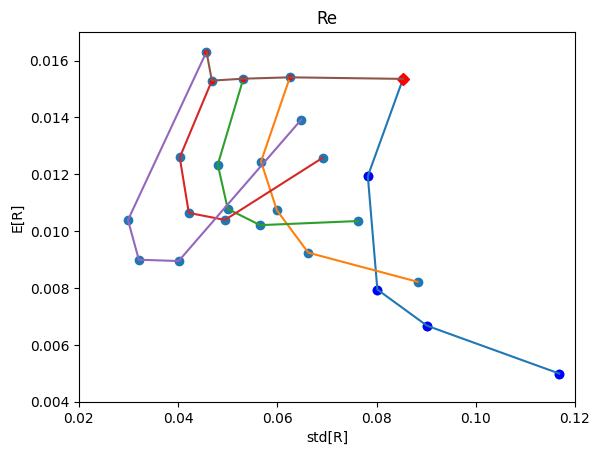

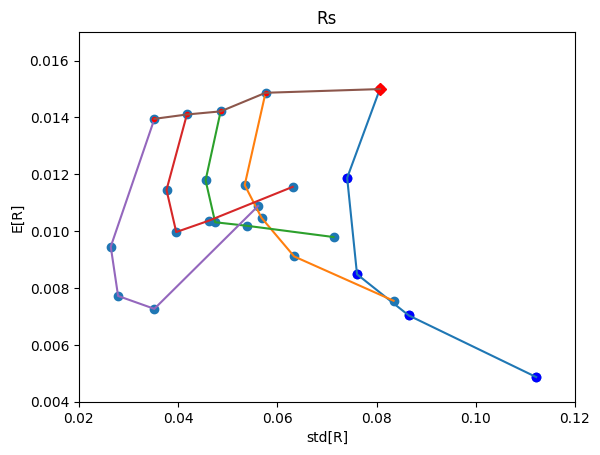

In [20]:
all_double_sort_plots('mu_sigma')

## Testing the ZCAPM Package


In [83]:
zcapm_results

,7 beta,7 zeta,15 beta,15 zeta,31 beta,31 zeta,58 beta,58 zeta,66 beta,66 zeta,...,18652 beta,18652 zeta,20247 beta,20247 zeta,20306 beta,20306 zeta,22186 beta,22186 zeta,30615 beta,30615 zeta
YearMonth,,,,,,,,,,,,,,,,,,,,,
196406,0.010368,-0.00956,0.008234,-0.011524,0.008611,-0.010811,0.00668,-0.010353,0.005396,-0.010337,...,0.004797,-0.010078,0.004645,-0.009926,0.017694,-0.014238,0.00895,-0.010658,0.027208,-0.010781


In [19]:
test = ZCAPM.Testing()

In [21]:
test.sorted_portfolio_monthly_excess_return.iloc[12:,:].index

Int64Index([196501, 196502, 196503, 196504, 196505, 196506, 196507, 196508,
            196509, 196510,
            ...
            201503, 201504, 201505, 201506, 201507, 201508, 201509, 201510,
            201511, 201512],
           dtype='int64', name='YearMonth', length=612)

In [56]:
#Set Parameters for rolling estimations and EM Algorithm. For information on parameters see doc string of _EM_loop method
tol = .001
MaxIter = 1000
criterion = 1
width = 12

######## IMPORTANT########
#trims off all of the first "width" amount of monthly returns to ensure that the Fama-MacBeth test is performed
#OUT OF SAMPLE
monthly_excess_return = test.sorted_portfolio_monthly_excess_return.iloc[width:,:]
portfolio_excess_return = test.sorted_portfolio_daily_excess_return
factor_return = test.factor_daily_return

YearMonth = monthly_excess_return.index

#create pandas series for mkt ret, mkt sigma, and factors. Convert indices of these series and portfolio return dataframe
#to be the YearMonth list. Useful for indexing purposes while testing
mu = (factor_return.loc[:,"R_a.R_f"])
sigma = (factor_return.loc[:,"sigma_a"])
facs_ret = factor_return.loc[:,['YearMonth','R_a.R_f','SMB','HML']]

mu.index = factor_return.YearMonth
sigma.index = factor_return.YearMonth
portfolio_excess_return.set_index('YearMonth',inplace = True)
facs_ret.set_index('YearMonth',inplace =True)

In [58]:
sigma

YearMonth
196401    1.51160
196401    1.44340
196401    1.42870
196401    1.46680
196401    1.22780
           ...   
201512    0.76288
201512    1.39370
201512    0.91048
201512    1.02140
201512    1.09850
Name: sigma_a, Length: 13091, dtype: float64

In [62]:
facs_ret

,R_a.R_f,SMB,HML
YearMonth,,,
196401,0.60,0.61,0.57
196401,0.17,0.11,0.39
196401,0.23,0.14,0.01
196401,0.04,0.08,0.76
196401,0.34,0.04,-0.15
...,...,...,...
201512,-0.11,0.30,-0.08
201512,-0.29,-0.49,-0.35
201512,1.05,0.09,-0.31


In [ ]:
#calculates time series factor loadings for each portfolio. See Testing class for information on the arguments of each
#method
zcapm_results = test.estZCAPM(portfolio_excess_return,mu,sigma,tol,MaxIter,criterion,width)
# ff3_results = test.estLinearModel(portfolio_excess_return,facs_ret,width)
# capm_results = test.estLinearModel(portfolio_excess_return,facs_ret.loc[:,['R_a.R_f']],width)

#adjust the zeta estimates for each portfolio to monthly estimates
zeta_cols = zcapm_results.columns[zcapm_results.columns.str.contains('zeta')]
zcapm_results.loc[:,zeta_cols] = zcapm_results.loc[:,zeta_cols]*21

In [ ]:
zcapm_results

,SMALL.LoBM beta,SMALL.LoBM zeta,ME1.BM2 beta,ME1.BM2 zeta,ME1.BM3 beta,ME1.BM3 zeta,ME1.BM4 beta,ME1.BM4 zeta,SMALL.HiBM beta,SMALL.HiBM zeta,...,BIG.LoBM beta,BIG.LoBM zeta,ME5.BM2 beta,ME5.BM2 zeta,ME5.BM3 beta,ME5.BM3 zeta,ME5.BM4 beta,ME5.BM4 zeta,BIG.HiBM beta,BIG.HiBM zeta
YearMonth,,,,,,,,,,,,,,,,,,,,,
196412,1.099749,-0.352402,1.002181,-0.210200,0.771063,0.500876,0.710273,0.004014,0.945831,0.499077,...,1.124476,-0.107168,0.834803,-0.160272,0.955905,0.184712,1.272193,-0.094054,1.350527,-0.155759
196501,1.060569,-0.113919,0.955749,-0.080973,0.747277,0.600714,0.691036,0.231385,0.929258,0.764179,...,1.122048,-0.059299,0.821589,-0.368722,0.988572,0.161355,1.262883,-0.110518,1.334198,-0.089832
196502,1.048046,-0.107963,0.933864,-0.078404,0.787325,0.621845,0.704563,0.419167,0.914045,0.819605,...,1.108315,-0.071948,0.834434,-0.347596,1.028872,0.156084,1.237076,-0.294047,1.344365,-0.381886
196503,1.034353,0.084690,0.917893,0.226941,0.822781,0.656015,0.717946,0.426505,0.910280,1.064458,...,1.108643,-0.014010,0.825842,-0.395529,1.038206,-0.045976,1.233576,-0.372574,1.361912,-0.091889
196504,0.986344,0.360841,0.914810,0.167825,0.835412,0.948003,0.707024,0.642613,0.884527,1.328441,...,1.129973,0.038474,0.817556,-0.568598,1.018836,-0.169676,1.219187,-0.431916,1.355104,-0.338629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201507,1.101494,-0.243116,1.033481,0.200763,0.973565,-0.572815,0.893294,-0.275749,0.786956,-0.707984,...,0.979922,0.459627,0.985791,0.087685,1.019801,-0.308904,0.998823,-0.746996,1.021590,-0.291420
201508,1.014193,-0.354925,0.968642,-0.042300,0.895075,-0.502718,0.820303,-0.191385,0.733233,-0.599921,...,1.005292,0.435372,0.996916,-0.044439,1.021598,-0.224758,0.999322,-0.635467,1.042385,-0.298744
201509,0.976435,-0.288037,0.939126,-0.214933,0.858127,-0.385946,0.781477,0.032363,0.713461,-0.636765,...,0.995680,0.364788,0.996467,-0.107497,1.029551,-0.169864,0.994847,-0.586142,1.056515,-0.431432


In [ ]:
zeta_cols

Index(['SMALL.LoBM zeta', 'ME1.BM2 zeta', 'ME1.BM3 zeta', 'ME1.BM4 zeta',
       'SMALL.HiBM zeta', 'ME2.BM1 zeta', 'ME2.BM2 zeta', 'ME2.BM3 zeta',
       'ME2.BM4 zeta', 'ME2.BM5 zeta', 'ME3.BM1 zeta', 'ME3.BM2 zeta',
       'ME3.BM3 zeta', 'ME3.BM4 zeta', 'ME3.BM5 zeta', 'ME4.BM1 zeta',
       'ME4.BM2 zeta', 'ME4.BM3 zeta', 'ME4.BM4 zeta', 'ME4.BM5 zeta',
       'BIG.LoBM zeta', 'ME5.BM2 zeta', 'ME5.BM3 zeta', 'ME5.BM4 zeta',
       'BIG.HiBM zeta'],
      dtype='object')

In [ ]:
zcapm_results.loc[:,zeta_cols]

,SMALL.LoBM zeta,ME1.BM2 zeta,ME1.BM3 zeta,ME1.BM4 zeta,SMALL.HiBM zeta,ME2.BM1 zeta,ME2.BM2 zeta,ME2.BM3 zeta,ME2.BM4 zeta,ME2.BM5 zeta,...,ME4.BM1 zeta,ME4.BM2 zeta,ME4.BM3 zeta,ME4.BM4 zeta,ME4.BM5 zeta,BIG.LoBM zeta,ME5.BM2 zeta,ME5.BM3 zeta,ME5.BM4 zeta,BIG.HiBM zeta
YearMonth,,,,,,,,,,,,,,,,,,,,,
196412,-0.352402,-0.210200,0.500876,0.004014,0.499077,-0.605331,-0.658862,0.684994,0.157181,0.503195,...,-0.156183,0.620258,0.340749,0.618030,-0.063821,-0.107168,-0.160272,0.184712,-0.094054,-0.155759
196501,-0.113919,-0.080973,0.600714,0.231385,0.764179,-0.077648,-0.314648,0.738219,0.402202,0.547969,...,0.173334,0.732824,0.560017,0.646730,0.041204,-0.059299,-0.368722,0.161355,-0.110518,-0.089832
196502,-0.107963,-0.078404,0.621845,0.419167,0.819605,0.053663,-0.031228,0.838520,0.536398,0.501555,...,0.146123,0.918986,0.668347,0.503446,0.028441,-0.071948,-0.347596,0.156084,-0.294047,-0.381886
196503,0.084690,0.226941,0.656015,0.426505,1.064458,0.174025,-0.185600,0.814180,0.408188,0.372989,...,0.138168,0.826827,0.423701,0.308734,0.355287,-0.014010,-0.395529,-0.045976,-0.372574,-0.091889
196504,0.360841,0.167825,0.948003,0.642613,1.328441,0.091722,0.159890,0.975288,0.631682,0.504741,...,0.393915,0.833792,0.444226,0.631056,0.517906,0.038474,-0.568598,-0.169676,-0.431916,-0.338629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201507,-0.243116,0.200763,-0.572815,-0.275749,-0.707984,0.370058,0.101120,-0.276387,-0.190859,-1.526293,...,0.487809,0.117967,0.036948,-0.337233,-0.822159,0.459627,0.087685,-0.308904,-0.746996,-0.291420
201508,-0.354925,-0.042300,-0.502718,-0.191385,-0.599921,0.056807,0.258155,-0.067565,-0.243410,-1.486250,...,0.352635,0.162528,0.080906,-0.154906,-0.778399,0.435372,-0.044439,-0.224758,-0.635467,-0.298744
201509,-0.288037,-0.214933,-0.385946,0.032363,-0.636765,0.018677,0.129148,-0.058712,0.001092,-1.148411,...,0.290824,0.217093,0.164061,-0.011268,-0.640843,0.364788,-0.107497,-0.169864,-0.586142,-0.431432


In [ ]:
#Runs the Fama-MacBeth Test for each portfolio
ZCAPM = test.FamaMacBeth(monthly_excess_return,zcapm_results,['beta','zeta'],'ZCAPM')
FF3 = test.FamaMacBeth(monthly_excess_return,ff3_results,['R_a.R_f','SMB','HML'],'Fama-French 3 Factor')
CAPM = test.FamaMacBeth(monthly_excess_return,capm_results,['R_a.R_f',],'CAPM')

In [ ]:
ZCAPM

,coefficients,t-values
ZCAPM,,
intercept,0.7593262880472017,3.0875681939793758
beta,-0.1783317961459172,-0.7265999715044813
zeta,0.4885823411522058,4.299951332644644
Single Regression Approach R-squared,0.9690609647879035,


In [ ]:
FF3

,coefficients,t-values
Fama-French 3 Factor,,
intercept,0.8899926349195396,4.625249967909042
R_a.R_f,-0.3742676286214684,-1.7778283203036696
SMB,0.18226260438326758,1.3752332078248828
HML,0.3025136631944703,2.5440381412417037
Single Regression Approach R-squared,0.6470600399973208,


In [ ]:
CAPM

,coefficients,t-values
CAPM,,
intercept,0.9215175378932576,3.738539529018011
R_a.R_f,-0.2986757946856537,-1.1877174962510997
Single Regression Approach R-squared,0.5198257918234428,
